# Define the libraries

In [209]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal

# Define Function

In [210]:
def PlotData(Start,Duration,Mistake,Time,Data1,Data2,Figuur,player,arraystartsprint,arraystopsprint,StartError,StopError,Sync): 
    
    #Define starting en stopping positions for the CSV data
    Start = int((Start-Mistake)*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    
    Timestamp = Time[Start:Stop]
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    Conv2 = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=1)
    DiffFrame = np.insert(DiffFrame,0,0)
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=1)
    DiffWheel = np.insert(DiffWheel,0,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    
    #Set all data into a datafram
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv','DiffFrame','DiffWheel'])
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4 and Rotate == False:
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4:
            Rotate = True
            Stop = False
        elif Stop == False:
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint),1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 3:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1 
                
    if str(StartError) == 'NaN':
        Startsprint = []
        Stopsprint = []
    elif len(Startsprint) == 0 and float(StartError) > 0:
        Startsprint = [StartError]
        Stopsprint = [StopError]
    elif float(StartError) > 0:
        for i in range(len(Startsprint)):
            Startsprint[i] = StartError
            Stopsprint[i] = StopError
    
    #Calculate vidoe time
    if (Start/100) < Sync[0][1]:
        Videotime = 0;
    elif (Start/100) < Sync[1][1]:
        Videotime = Sync[0][0] + ((Start/100)-Sync[0][1])
    elif (Start/100) < Sync[2][1]:
        Videotime = Sync[1][0] + ((Start/100)-Sync[1][1])
    elif (Start/100) < Sync[3][1]:
        Videotime = Sync[2][0] + ((Start/100)-Sync[2][1])
    else:
        Videotime = Sync[3][0] + ((Start/100)-Sync[3][1])    
                                   
    #Plot graph  
    fig, ax = plt.subplots(1,1)
    ax.plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')   
    
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax.axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax.axvline(x=Stop, color = 'm')
    ax.legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax.set_xlabel('Time (sec)')
    ax.set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(timedelta(seconds = int(Videotime))))
    
    ArrayStartSprint.append(Startsprint)
    ArrayStopSprint.append(Stopsprint)

# Visualize Data
## Define player and match

In [211]:
Player = 15
Game = 2

## Insert Data player

In [212]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.00000,0.000000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,0.000000,0.0,0.0,0.00000,0.000000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
2,0.000000,0.0,0.0,0.00000,0.000000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,0.000000,0.0,0.0,0.00000,0.000000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
4,0.000000,0.0,0.0,0.00000,0.000000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
860405,-0.002098,6556.8,-1946.6,-0.18538,-0.000787,8604.10,1.0500,0.85556,-1.0500,1.4000,1.16670,-1.5867,-0.40135
860406,-0.026347,6556.8,-1946.6,-0.18939,-0.000808,8604.10,1.0920,0.93100,-1.0710,1.4000,1.09200,-1.6240,-5.03910
860407,0.012933,6556.8,-1946.6,-0.23979,-0.001071,8604.10,1.1690,0.95900,-1.1200,1.4000,1.08110,-1.5089,NaN
860408,NaN,NaN,NaN,NaN,NaN,NaN,1.1433,0.93333,-1.0967,1.4000,1.08500,-1.4700,NaN


## Define boundaries
### Get Timestamps from CSV

In [213]:
df_Timestamps = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_FoundSprints.csv')
Timestamps = df_Timestamps['Time'].to_numpy()
len(Timestamps)

114

# Fix Error things

In [214]:
StartError = [
              'NaN','NaN','NaN','NaN','NaN',1716.6,'NaN',1838.5,'NaN','NaN','NaN','NaN',2198,'NaN','NaN','NaN','NaN','NaN',
              2266.3,'NaN','NaN','NaN','NaN','NaN',2416.9,2593.2,'NaN',2808.5,3030.5,'NaN','NaN',3148.2,'NaN','NaN',3346,
              3397.3,'NaN','NaN','NaN','NaN',3799.4,'NaN','NaN',3850.7,'NaN',3968.8,'NaN','NaN',4053.6,'NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN','NaN','NaN',4932.6,'NaN',4955,'NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN',6600,
              'NaN','NaN','NaN','NaN','NaN','NaN',7084.6,'NaN','NaN','NaN',7228.6,7244,7475.5,'NaN',7692,'NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN',7924.4,7974.2,'NaN'
             ]

StopError =  [
              'NaN','NaN','NaN','NaN','NaN',1720,'NaN',1840.5,'NaN','NaN','NaN','NaN',2201,'NaN','NaN','NaN','NaN','NaN',
              2269.5,'NaN','NaN','NaN','NaN','NaN',2419.7,2596,'NaN',2811,3033.3,'NaN','NaN',3151,'NaN','NaN',3349.7,
              3400.5,'NaN','NaN','NaN','NaN',3803.4,'NaN','NaN',3852.5,'NaN',3973.5,'NaN','NaN',4056.5,'NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN','NaN','NaN',4934.9,'NaN',4960.7,'NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN','NaN',6603.5,
              'NaN','NaN','NaN','NaN','NaN','NaN',7086.3,'NaN','NaN','NaN',7231.8,7246.7,7478.2,'NaN',7694,'NaN','NaN','NaN',
              'NaN','NaN','NaN','NaN','NaN',7927.6,7978.3,'NaN'
             
            ]
len(StartError)

114

In [215]:
df_Sync = pd.read_csv('Sync_match_' + str(Game) + '.csv')
df_Sync_Player = df_Sync.loc[df_Sync["Player"] == Player]
Times = df_Sync_Player[["Video","Matlab"]].to_numpy()
Times

array([[  47.4 , 3580.  ],
       [1376.32, 4903.  ],
       [2454.12, 6473.8 ],
       [3651.6 , 7668.7 ]])

### Visualize

<ipython-input-210-016f61b4ca0e>:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


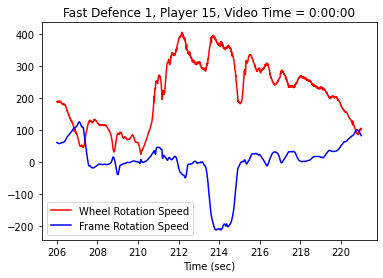

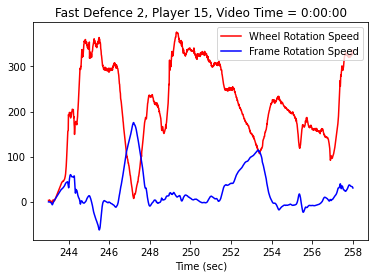

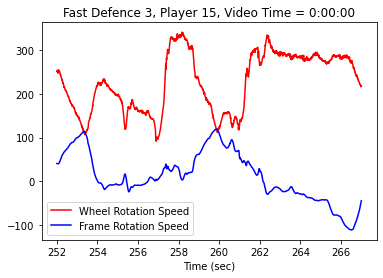

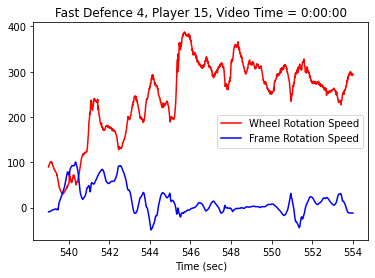

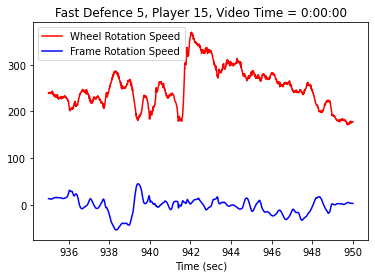

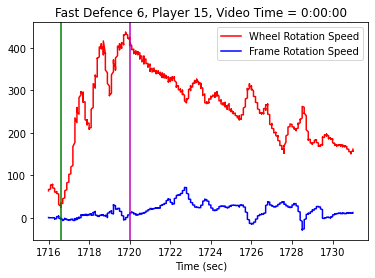

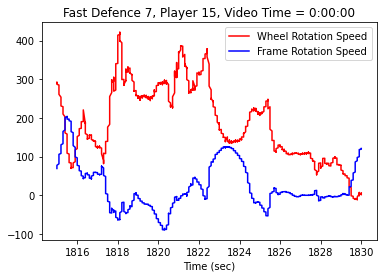

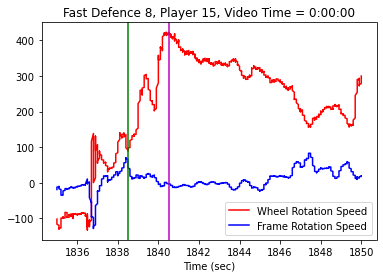

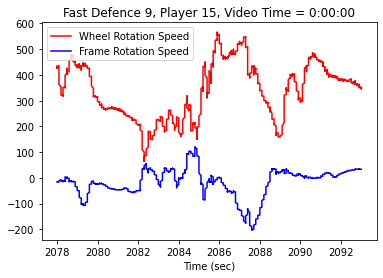

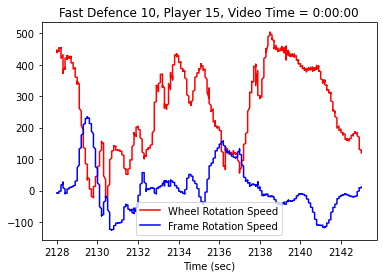

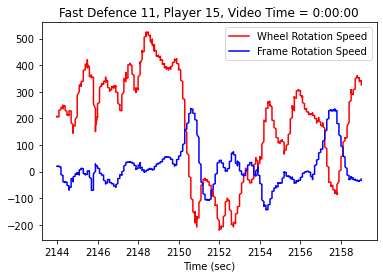

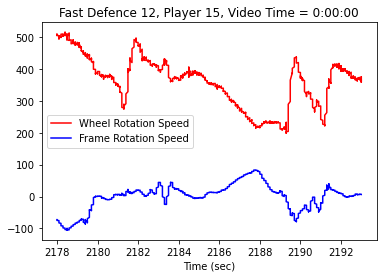

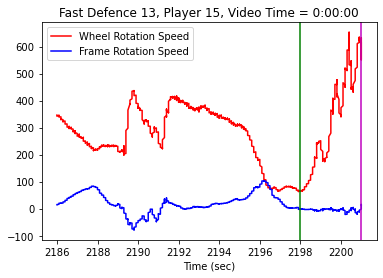

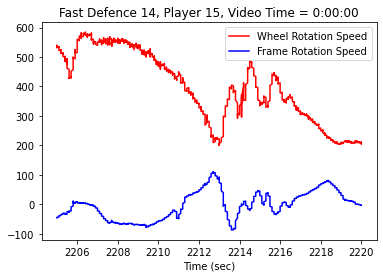

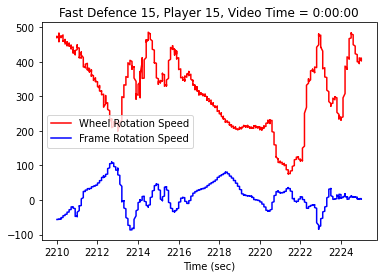

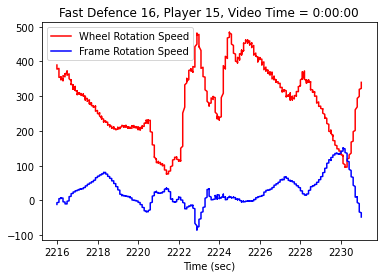

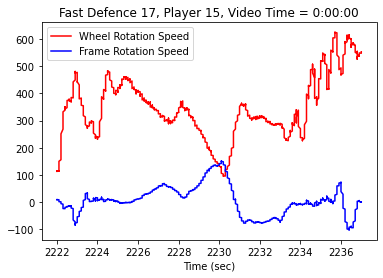

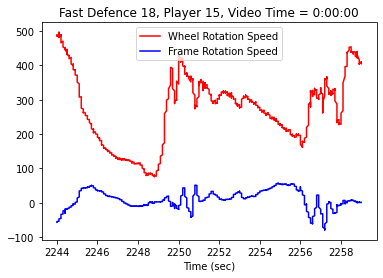

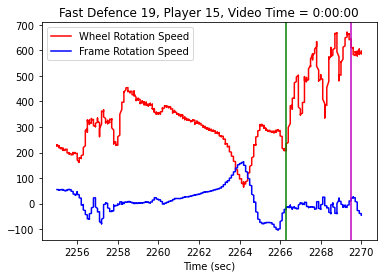

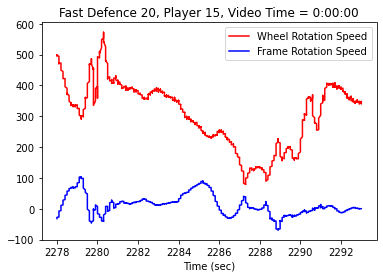

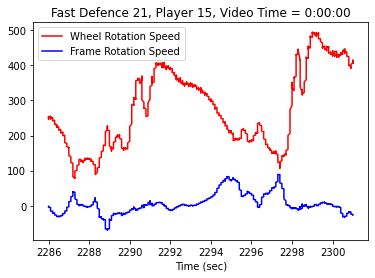

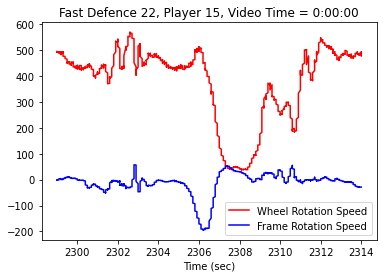

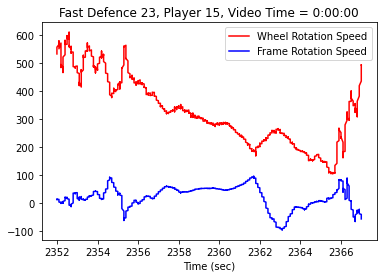

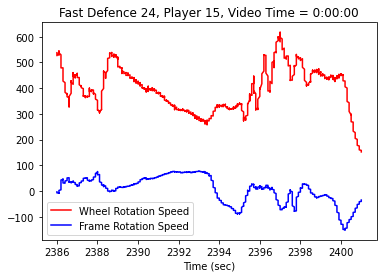

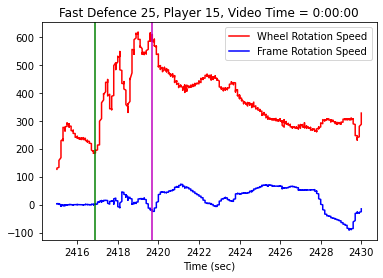

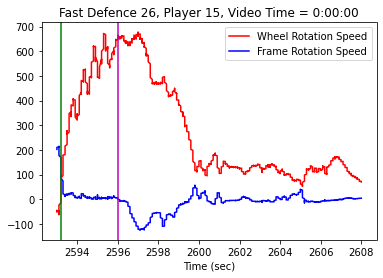

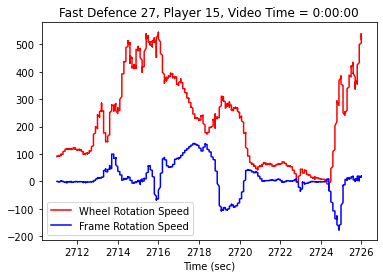

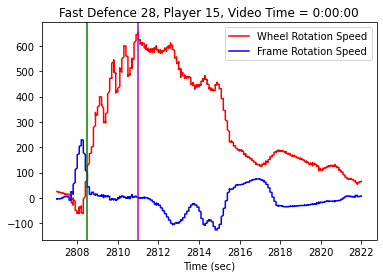

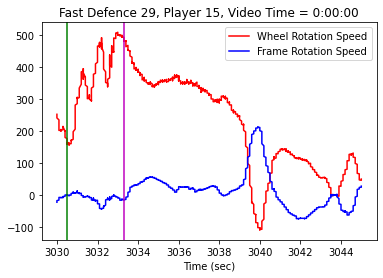

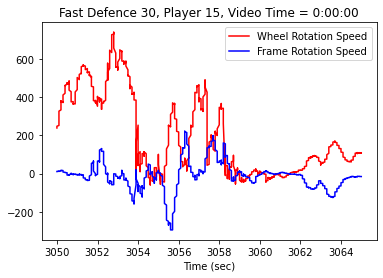

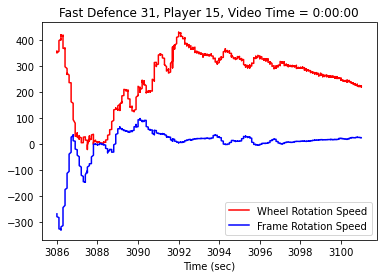

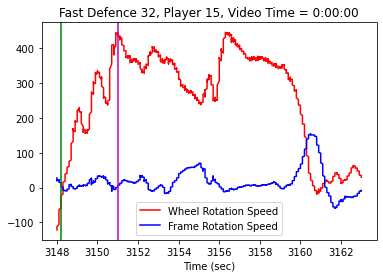

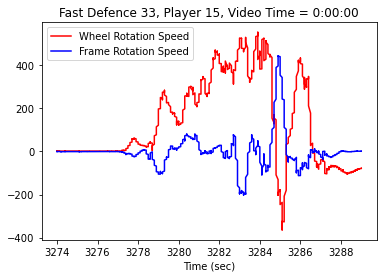

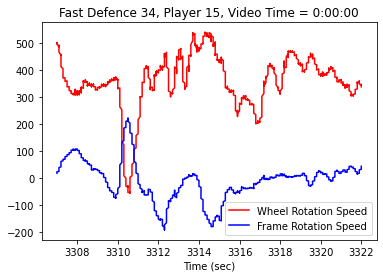

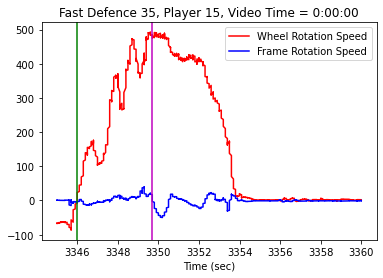

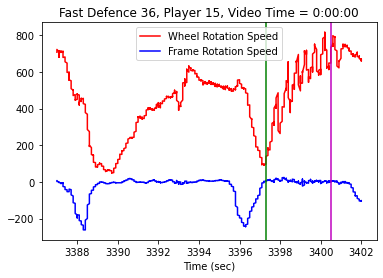

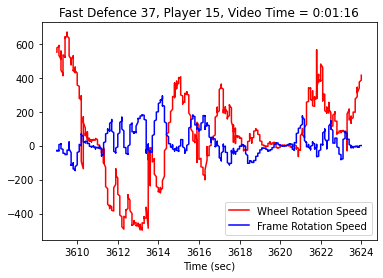

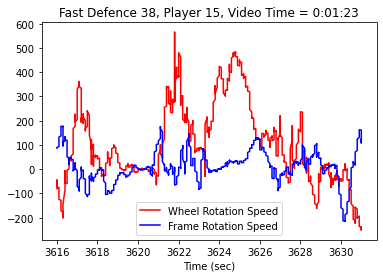

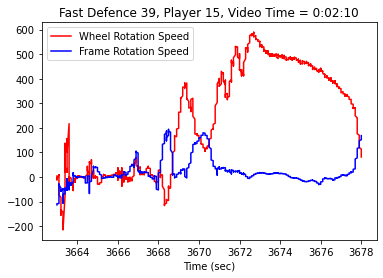

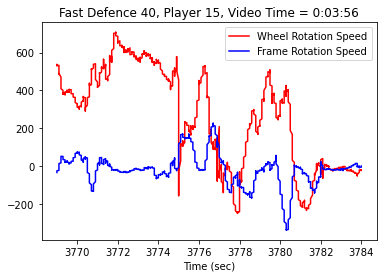

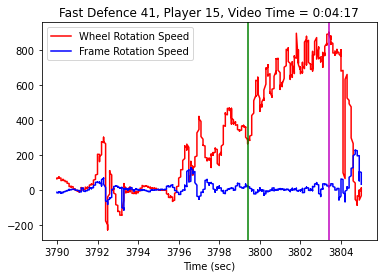

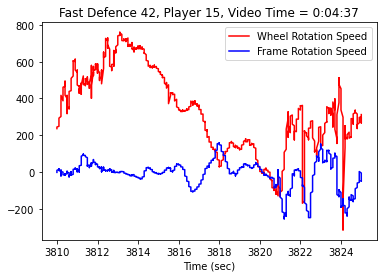

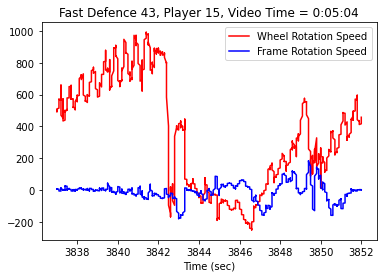

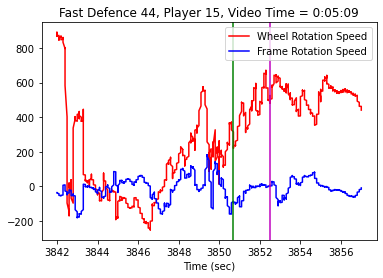

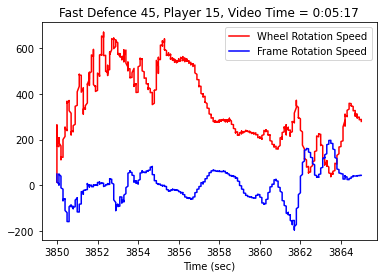

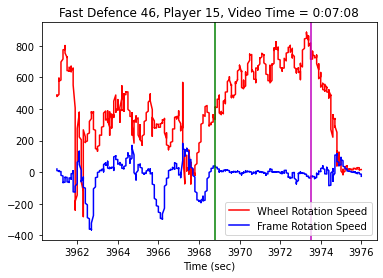

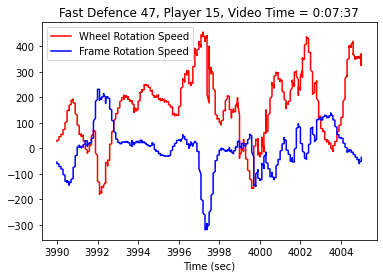

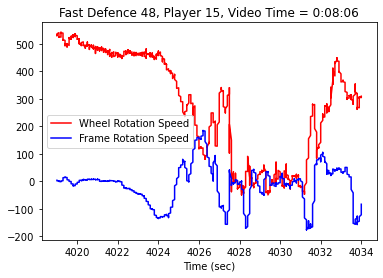

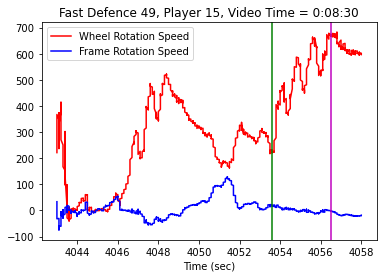

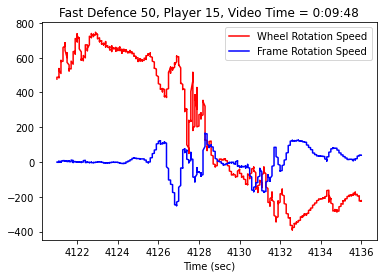

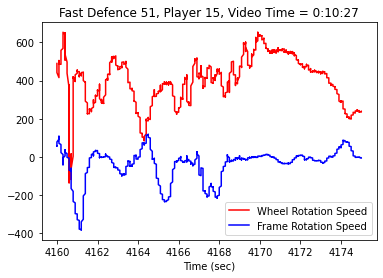

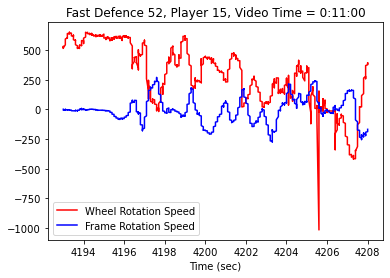

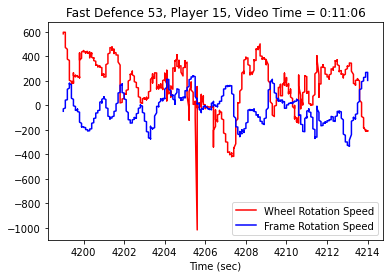

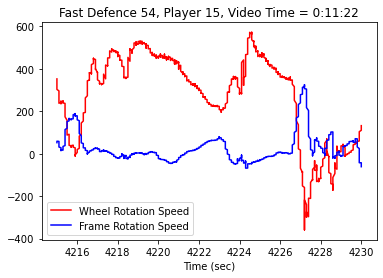

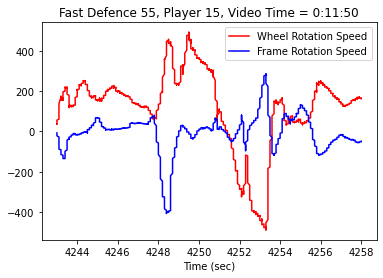

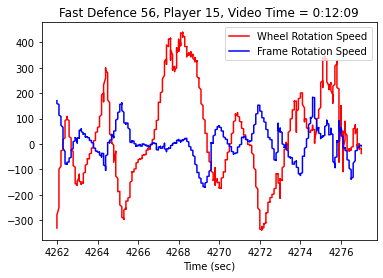

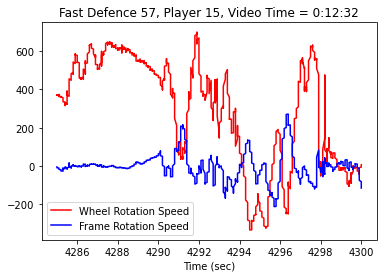

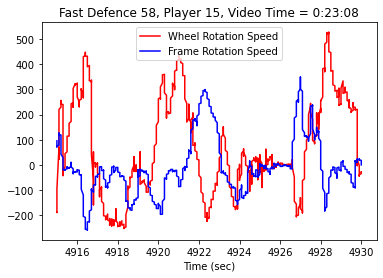

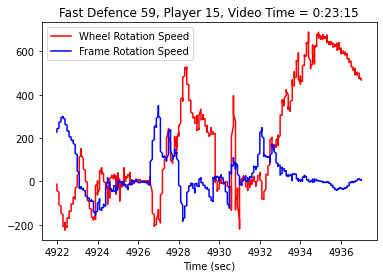

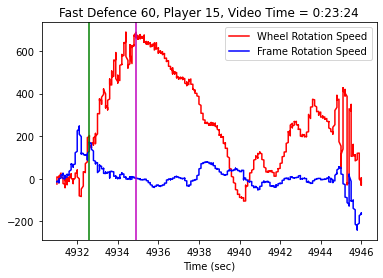

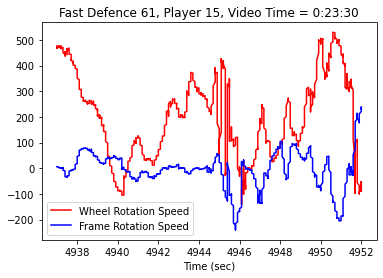

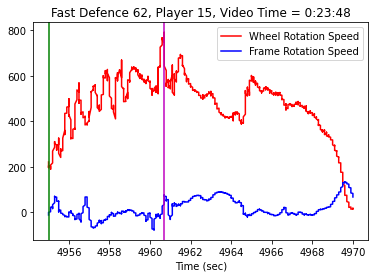

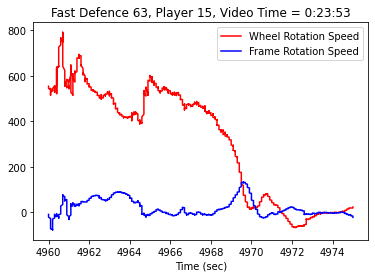

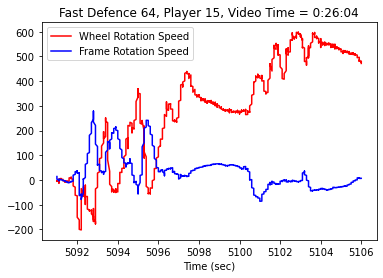

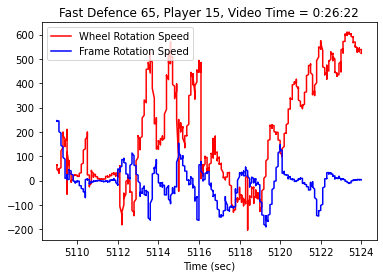

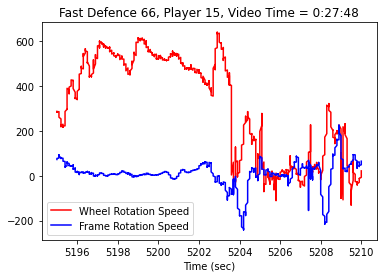

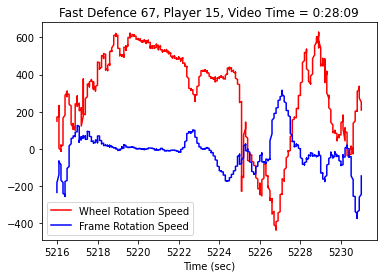

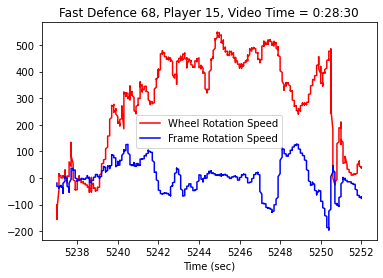

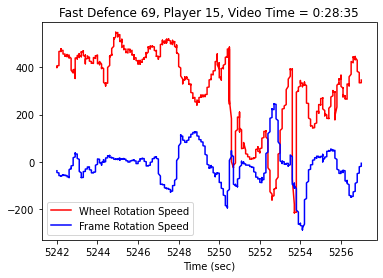

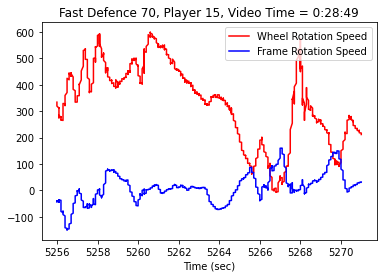

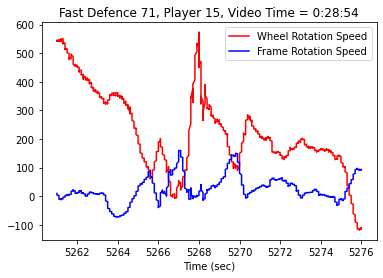

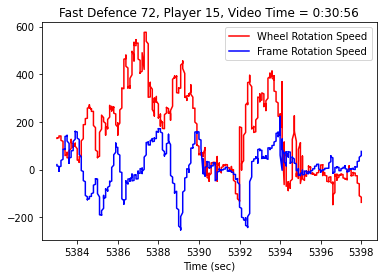

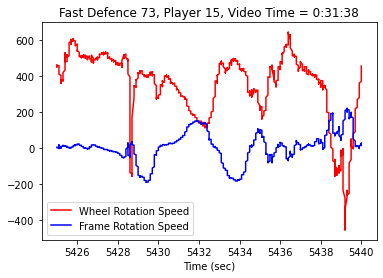

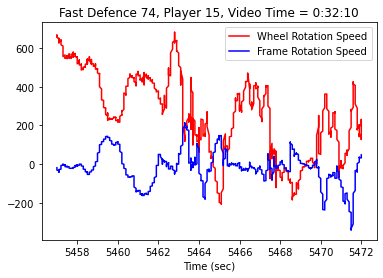

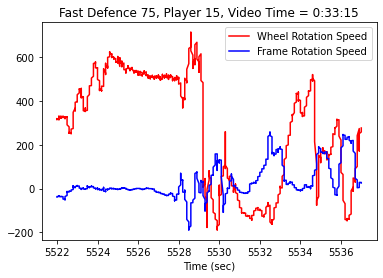

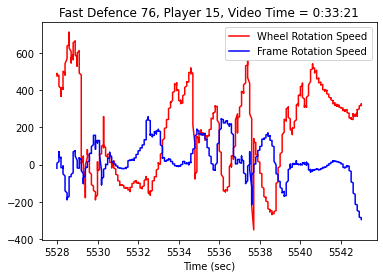

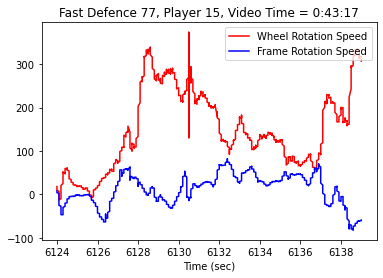

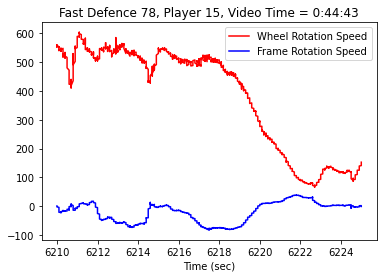

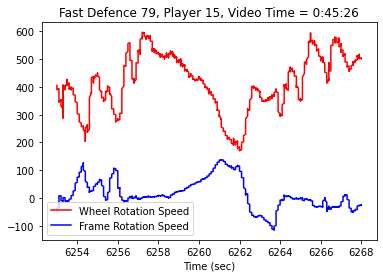

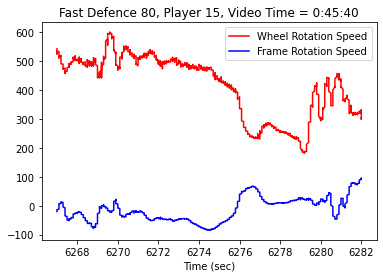

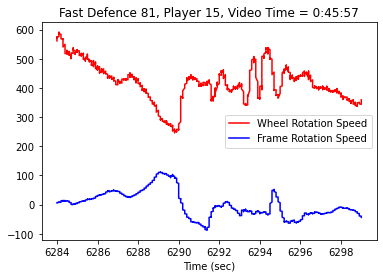

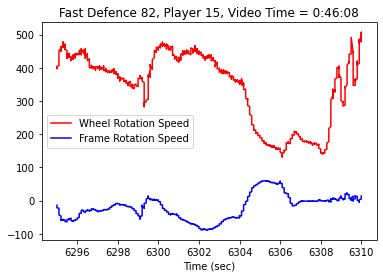

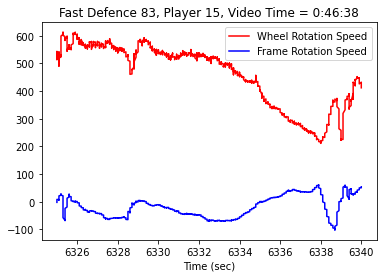

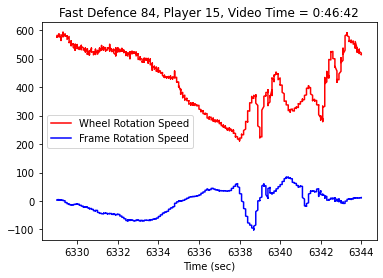

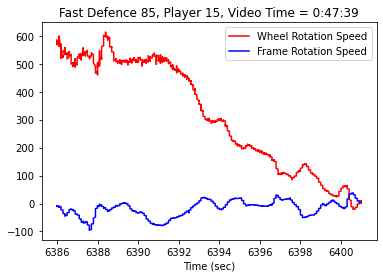

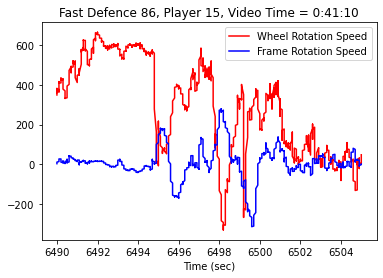

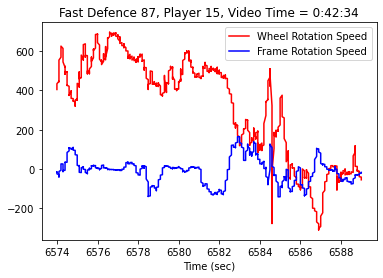

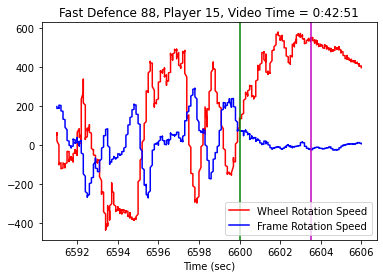

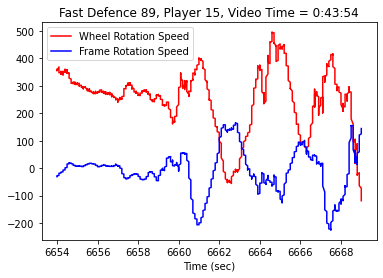

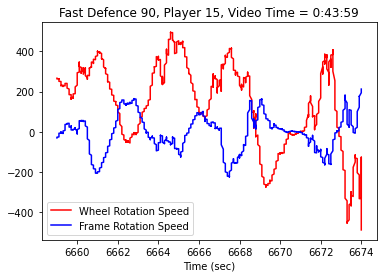

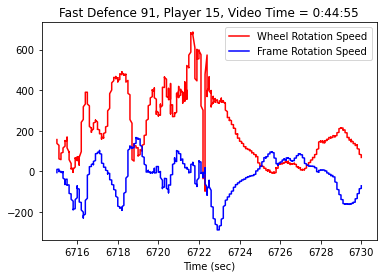

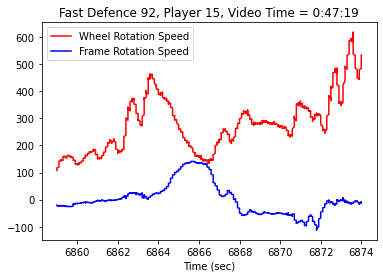

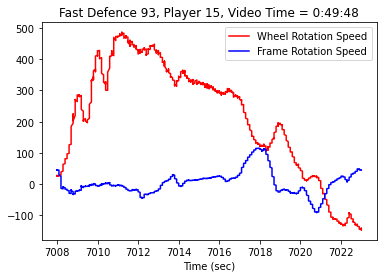

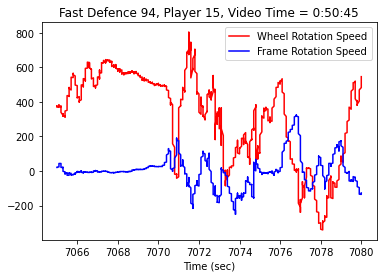

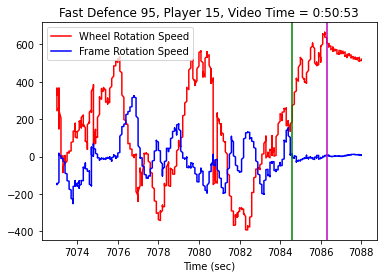

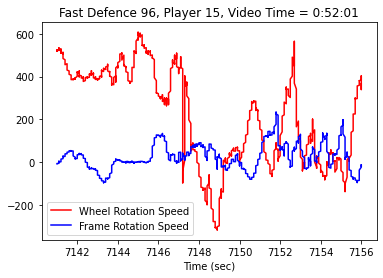

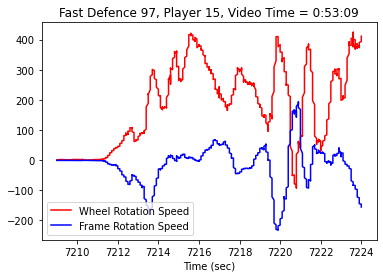

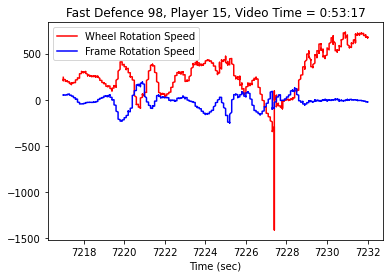

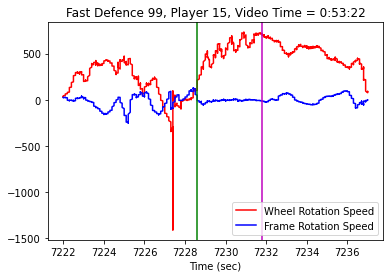

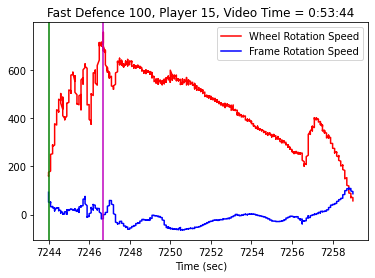

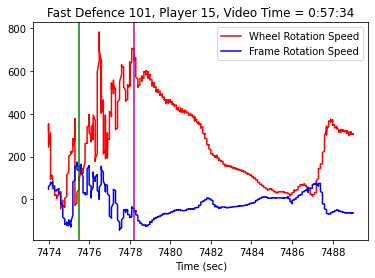

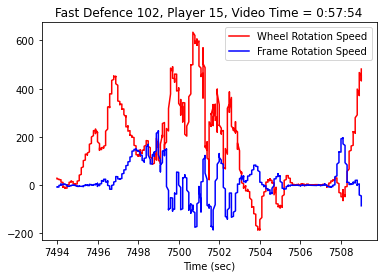

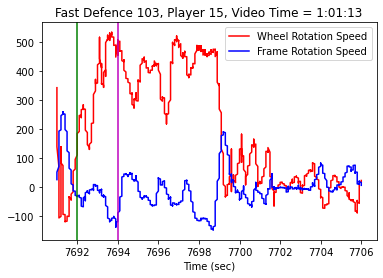

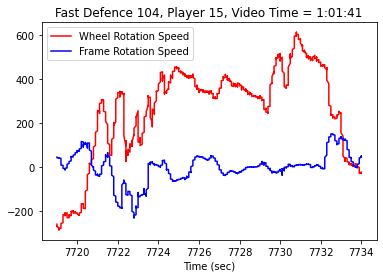

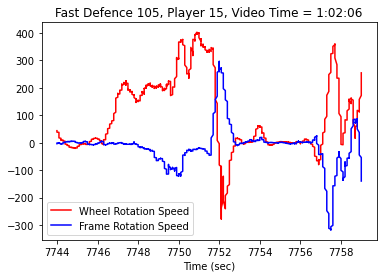

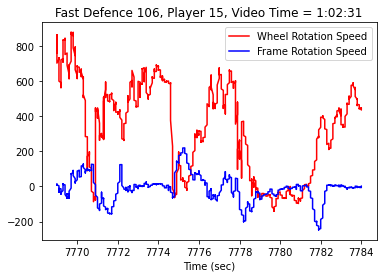

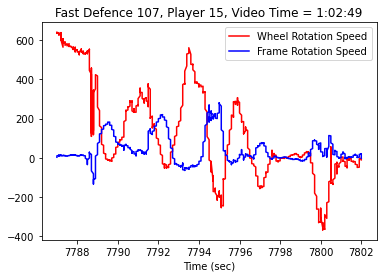

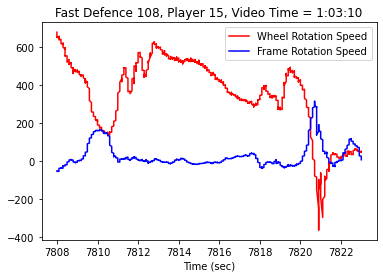

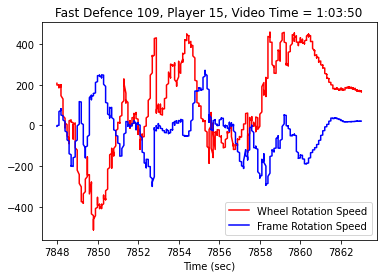

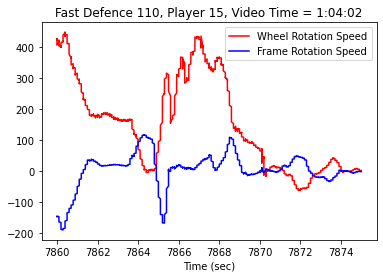

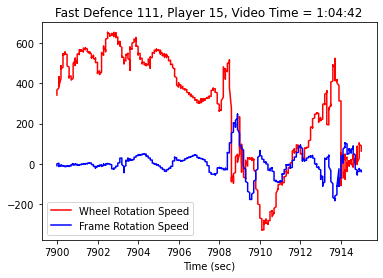

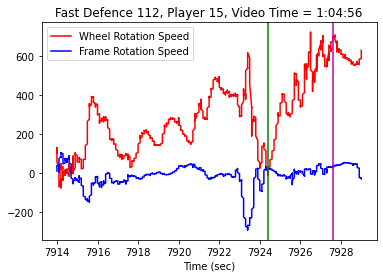

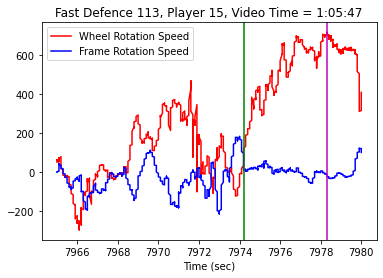

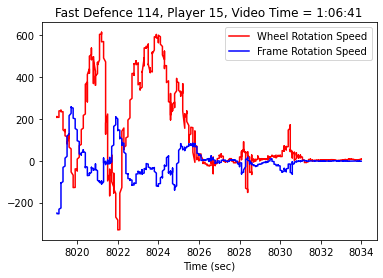

In [216]:
ArrayStartSprint = []
ArrayStopSprint = []
for i in range(0,len(Timestamps),1):
     PlotData(Timestamps[i], 15,5, df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),ArrayStartSprint, ArrayStopSprint,StartError[i],StopError[i],Times)

In [217]:
Startsprint =[]
Stopsprint = []

df_Filter = df_Player
df_Filter = df_Filter.fillna(0)

Order = 5 
cutoff_freq = 1.5
sampling_freq = 100
sampling_duration = len(df_Filter.wheelRotationalSpeedX)/100

  
normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)

filtered_WheelRotationspeedX = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.wheelRotationalSpeedX)
filtered_FrameRotationspeedZ = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.frameRotationalSpeedZ)


df_Player['Sum_WheelX_FrameZ']  = df_Player.wheelRotationalSpeedX + df_Player.frameRotationalSpeedZ
df_Player['Div_FrameZ_WheelX']  = df_Player.frameRotationalSpeedZ / df_Player.wheelRotationalSpeedX
df_Player['Filt_WheelX'] = filtered_WheelRotationspeedX
df_Player['Filt_FrameZ'] = filtered_FrameRotationspeedZ

for start in ArrayStartSprint:
    for time in start:
        Startsprint.append(time)

for stop in ArrayStopSprint:
    for time in stop:
        Stopsprint.append(time)
        
#df_Player_Action = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

df_Player['Action'] = df_Player_Action['Action']
        
for i  in range(0,len(Startsprint)):
    df_Player['Action'].iloc[int(Startsprint[i]*100):int(Stopsprint[i]*100)] = 1
        
#df_Player.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')



NameError: name 'df_Player_Action' is not defined